# Forecasting Experiments

Try different forecasting methods on 2 representative sample data, try to see whether we can find a method works for both time series in order to forecast well.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [10]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean().dropna()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean().dropna()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean().dropna()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean().dropna()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(97,) (97,) (11,) (7,)


purchase_date
2019-05-25    3.748604
2019-05-26    3.671921
2019-05-27    3.625118
2019-05-28    3.512122
2019-05-29    3.391662
Name: client_count, dtype: float64

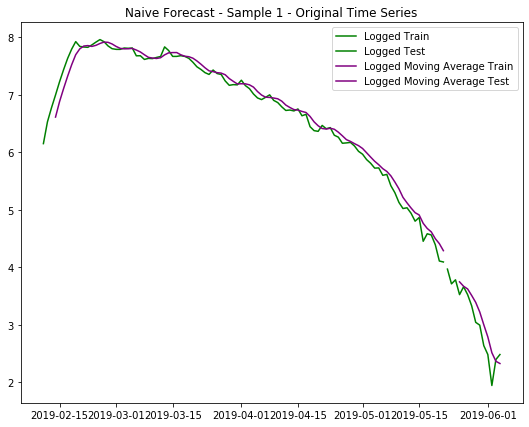

In [17]:
plt.figure(figsize=(9,7))
plt.plot(ts_log_train1.index, ts_log_train1, label='Logged Train', color='green')
plt.plot(ts_log_test1.index, ts_log_test1, label='Logged Test', color='green')
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Logged Moving Average Train', color='purple')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, label='Logged Moving Average Test', color='purple')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 - Original Time Series")
plt.show()

## Logged Time Series

* Without using logged moving average but just use the logged original time series.
  * Because logged time series has no null value and keeps the original time series pattern.
  * It's in the same scale as logged moving average, which makes the comparison between RMSE values easier.
* Compare between different forecasting methods, to see which one works better for the original time series.

### Approach 1 - Weighted Naive Forecast

* As we can see logged ts is in dropping trend. So we can assume testing data is w*latest_window of training data.
  * Latest window of training data has the same size as the testing data, and it's the closest to the testing data.
  * w is the weight. We can assume there is a linear regression relationshio between testing data and the latest window of the training data.
    * The reason I chose w=2/3 here is because the latest window of training data is between [4, 6], while the testing data seems between [2, 4].
    * Also tried a few other weights and this one works better.

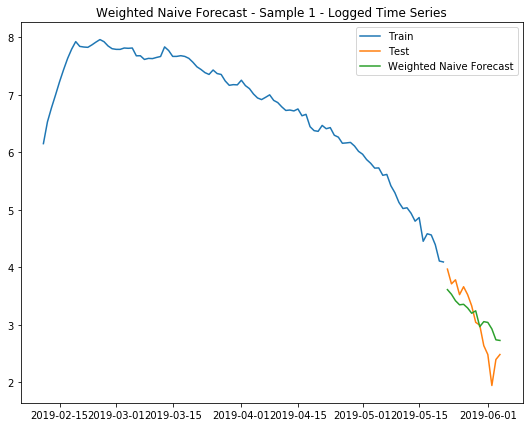

RMSE: 0.39276349567356206


In [26]:
train = ts_log_train1.copy()
test = ts_log_test1.copy()
w = 2/3
y_pred = train.iloc[-len(test):]*w
y_pred.index = test.index

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(y_pred.index, y_pred, label='Weighted Naive Forecast')
plt.legend(loc='best')
plt.title("Weighted Naive Forecast - Sample 1 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

### Approach 2 - Exponetial Smoothing

* The idea is, the weights will decrease from the latest to the oldest data
* `Yt+1 = α*Yt + α(1-α)*Yt-1 + α(1-α)(1-α)*Yt-2 + ... + α*pow(1-α, n)*Yt-n`
  * α is in [0,1] range

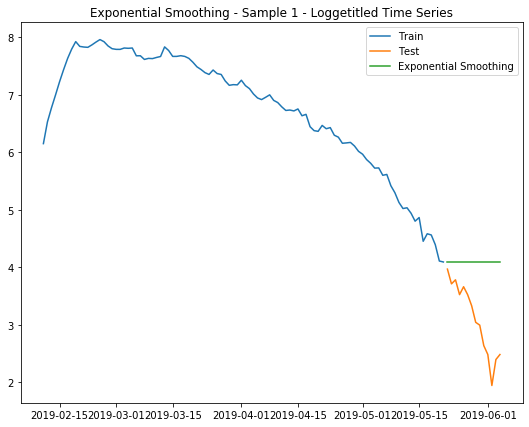

RMSE: 1.1580401582283357


In [51]:
title = 'Exponential Smoothing'

train = ts_log_train1.copy()
test = ts_log_test1.copy()

model_fit = SimpleExpSmoothing(np.array(train)).fit(smoothing_level=0.99,optimized=False)
y_pred = model_fit.forecast(len(test))

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 1 - Loggetitled Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

#### Note

* The exponential smoothing appears like a horizontal line might be because it puts too much weights on the last time point. 
* Larger `α` (smoothing level), smaller RMSE, but also means higher weights on latest time points. So overall looks like constant over the time.
